# Libs:

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_wine

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import optuna
from optuna.visualization.matplotlib import plot_param_importances


from xgboost import XGBClassifier

# Format data

In [27]:
X, y = load_wine(return_X_y=True, as_frame=True)

In [28]:
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [29]:
y

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42)

## Fit the base model

In [31]:
model = XGBClassifier(
                      use_label_encoder=False, 
                      eval_metric='mlogloss')

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
%%time

y_pred = model.predict(X_test)

CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 8.96 ms


In [33]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 96.29630%


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.95      0.95      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



# Optuna

## Optuna func

In [35]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [36]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [37]:
study = optuna.create_study(direction='maximize',study_name='XGBoost')

In [38]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.9814814814814815
  Params: 
    max_depth: 9
    learning_rate: 0.010285887242614972
    n_estimators: 270
    min_child_weight: 1
    gamma: 8.426228668247332e-06
    subsample: 0.11307440927227752
    colsample_bytree: 0.022495825556873895
    reg_alpha: 1.0243044469901093e-07
    reg_lambda: 0.024539574735171602


In [40]:
trial.params

{'max_depth': 9,
 'learning_rate': 0.010285887242614972,
 'n_estimators': 270,
 'min_child_weight': 1,
 'gamma': 8.426228668247332e-06,
 'subsample': 0.11307440927227752,
 'colsample_bytree': 0.022495825556873895,
 'reg_alpha': 1.0243044469901093e-07,
 'reg_lambda': 0.024539574735171602}

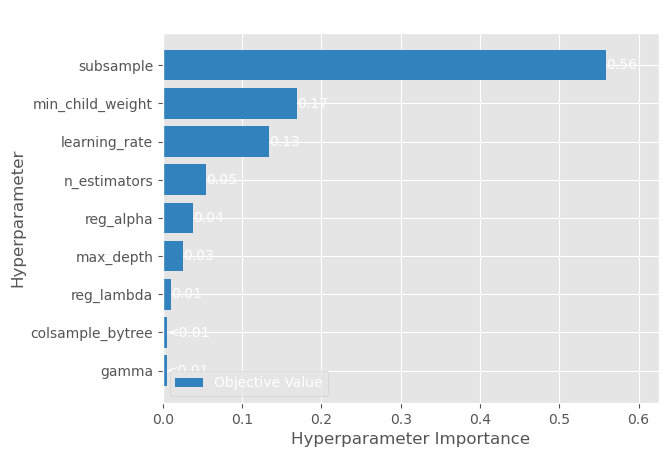

In [41]:
plot_param_importances(study);

In [42]:
params = trial.params

# XGBoost Classifier

In [43]:
trial.params

{'max_depth': 9,
 'learning_rate': 0.010285887242614972,
 'n_estimators': 270,
 'min_child_weight': 1,
 'gamma': 8.426228668247332e-06,
 'subsample': 0.11307440927227752,
 'colsample_bytree': 0.022495825556873895,
 'reg_alpha': 1.0243044469901093e-07,
 'reg_lambda': 0.024539574735171602}

In [44]:
model = XGBClassifier(**params)

In [45]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.022495825556873895, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=8.426228668247332e-06,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010285887242614972,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=270, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
%%time

y_pred = model.predict(X_test)

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 10.7 ms


In [47]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

Accuracy after tuning: 98.15%


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

